In [51]:
%load_ext autoreload
%autoreload 2
import os, sys
import glob
import json
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/')
sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/modeling/careful-whisper/')

from config import *
# import careful_whisper_utils as whisper
from src.models.components.careful_whisper import CarefulWhisper, CarefulWhisperConfig
from src.data.components.audio_text_dataset import AudioTextDataset
from src.data.audio_text_datamodule import AudioTextDataModule

# from torch.utils.data import DataLoader
# from src.data.components.collators import audio_text_collator


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-03-26 21:09:19.806686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743037760.151257 2377840 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743037760.258639 2377840 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-26 21:09:21.176705: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
T

In [7]:
json_path = os.path.join(DATASETS_DIR, 'nlp-datasets', 'av-combined', 'features', 'metadata', 'gpt2-wav2vec2-data2vec', 'train', 'metadata.json')

In [8]:
with open(json_path, 'r') as f:
    data = json.load(f)

In [11]:
sum([x['duration'] for x in data]) / 3600

1065.02036

### Functions for processing data into CSV

In [3]:
results_dir = os.path.join(BASE_DIR, 'derivatives/results/behavioral/')
out_fn = os.path.join(results_dir, f'all-subsets_careful-whisper_model-comparisons.csv')

df_results = pd.read_csv(out_fn)

In [11]:
df_test = df_results[df_results['true_subset'] >= 10]

df_test = df_test[df_test['main_model'] == 'ProsodyXAttn']

In [134]:
def batch_average(df, batch_size, columns):
    """
    Average a DataFrame into batches of specified size.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame to be batched
    batch_size (int): Size of each batch
    
    Returns:
    pandas.DataFrame: DataFrame with averaged batches
    """
    # Calculate number of complete batches
    n_batches = len(df) // batch_size
    
    # Handle case where DataFrame length isn't divisible by batch_size
    remainder = len(df) % batch_size
    
    # If there's no perfect division, we'll need one more batch
    if remainder > 0:
        n_batches += 1
    
    # Create list to store batch averages
    batch_averages = []
    
    # Process complete batches
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(df))  # Use min to handle last batch
        
        # Calculate average for current batch
        batch_avg = df.iloc[start_idx:end_idx]
        batch_avg = batch_avg[columns].median()
        batch_avg['batch_number'] = i  # Add batch number for reference
        batch_averages.append(batch_avg)
    
    # Combine all batch averages into a new DataFrame
    return pd.DataFrame(batch_averages)

def get_dataset_models(model_names, datasets, subsets=None):
    """Create model config variations for different subset sizes."""
    variations = {}
    
    for dataset in datasets:
        for model_name, model_type in model_names.items():

            # Add full dataset version
            if subsets is not None:
                for subset in subsets:
                    # variations[f'{dataset}_{model_name}-subset-{subset:.2f}'] = f'{model_type}'
                    variations[f"{model_name}_subset-{str(subset).zfill(3)}"] = f'{model_type}'

                # Also add base model
                variations[f'{dataset}_{model_name}'] = model_type
            else:
                variations[f'{dataset}_{model_name}'] = model_type
            
    return variations

MODEL_GROUPS = {
    'audio-main': {
        # f'careful-whisper_causal-xattn': 'AudioXAttn',
        # f'prosody-whisper_causal-xattn': 'ProsodyXAttn',
        # f'careful-whisper_no-xattn': 'GPT2',
    },
    'av-main': {
        f'audiovisual-careful-whisper_causal-xattn_token-fusion-mlp': 'AudioVisualXAttn',
        f'audio-careful-whisper_causal-xattn': 'AudioXAttn',
        f'prosody-careful-whisper_causal-xattn': 'ProsodyXAttn',
        f'text-careful-whisper_no-xattn': 'GPT2',
    },
    'av-subsets': {
        f'audiovisual-careful-whisper_causal-xattn': 'AudioVisualXAttn',
        f'audio-careful-whisper_causal-xattn': 'AudioXAttn',
        f'prosody-careful-whisper_causal-xattn': 'ProsodyXAttn',
        f'text-careful-whisper_no-xattn': 'GPT2',
    }
}

In [ ]:
dataset = 'av-combined'
group = 'av-subsets'
batch_size = 32

subsets = np.arange(0.1, 1, 0.1).tolist()
subsets += (np.logspace(0.3, 1.4, 10) / 100).tolist()
subsets = (100 * np.sort(np.round(subsets, 2))).astype(int) 

model_names = MODEL_GROUPS[group]
dataset_model_names = get_dataset_models(model_names, [dataset], subsets)

results_fns = glob.glob(os.path.join(BASE_DIR, f'derivatives/results/careful-whisper/{dataset}/*'))

results_fns = sorted(results_fns)

# now remove dataset names for dataset model names
dataset_model_names = {'_'.join(k.split('_')[1:]): v for k, v in dataset_model_names.items()}
df_results = []

sys.exit(0)
# Load the data and note the dataset name
for i, fn in tqdm(enumerate(results_fns), desc='Loading results'):

    base_name = os.path.splitext(os.path.basename(fn))[0]
    base_name = base_name.split('_')

    dataset_name = base_name[0]

    if 'subset' in group:
        model_name = '_'.join(base_name[1:3])
    else:
        model_name = '_'.join(base_name[1:-1])
    
    df = pd.read_csv(fn)
    df = batch_average(df, batch_size=batch_size, columns=['loss', 'perplexity', 'accuracy'])

    df['dataset'] = dataset_name
    df['model_name'] = model_name
    # df['perplexity'] = np.exp(df['loss'])

    if 'subset' in group:
        subset_name = base_name[-2]

        if 'subset' not in subset_name:
            current_subset = 100
        else:
            current_subset = subset_name.split('-')[-1]
        
        df['subset'] = int(current_subset)

    df_results.append(df)

df_results = pd.concat(df_results).reset_index(drop=True)

# Get order of models by binary accuracy
ordered_accuracy = df_results.loc[:,['dataset', 'model_name', 'accuracy', 'perplexity']] \
    .groupby(['dataset', 'model_name']) \
    .mean() \
    .reset_index()

# get max chance of null models
accuracy_chance = ordered_accuracy.loc[null_models, 'accuracy'].max()
perplexity_chance = ordered_accuracy.loc[null_models, 'perplexity'].min()

# Get overall model ordering (averaged across datasets)
ordered_models = ordered_accuracy \
    .groupby('model_name')[['accuracy']] \
    .mean() \
    .sort_values(by='accuracy') \
    .index.tolist()

# Sort by dataset and accuracy to match the bar order
ordered_accuracy = ordered_accuracy.sort_values(by=['dataset', 'accuracy']) #.reset_index(drop=True)

dataset_order = ordered_accuracy['dataset'].unique()
model_order = ordered_accuracy['model_name'].unique()

# Create a multi-index DataFrame to ensure values are in the right order
ordered_values = []
for model in model_order:
    for dataset in dataset_order:
        row = ordered_accuracy[
            (ordered_accuracy['dataset'] == dataset) & 
            (ordered_accuracy['model_name'] == model)
        ].iloc[0]

        acc = row['accuracy']
        ppl = row['perplexity']
        ordered_values.append((acc, ppl))

ordered_acc_values, ordered_ppl_values = zip(*ordered_values)

# remove the null models
df_results['model_name'] = df_results['model_name'].apply(lambda x: dataset_model_names[x])
ordered_models = [dataset_model_names[model] for model in ordered_models]

df_results = df_results.sort_values(by=['dataset', 'accuracy'], ascending=[True, False])

Loading results: 68it [01:20,  1.19s/it]


In [159]:
df_results

,loss,perplexity,accuracy,batch_number,dataset,model_name,subset
25615,2.988874,19.863647,0.464286,7.0,av-combined,AudioVisualXAttn,90
25297,2.922636,18.590600,0.430020,465.0,av-combined,AudioVisualXAttn,80
10095,3.169132,23.793659,0.428571,7.0,av-combined,AudioXAttn,60
22511,3.213634,24.871080,0.414286,7.0,av-combined,AudioVisualXAttn,50
26383,3.315542,27.537315,0.413793,775.0,av-combined,AudioVisualXAttn,90
...,...,...,...,...,...,...,...
41936,5.328114,206.205105,0.000000,32.0,av-combined,GPT2,5
42700,6.543602,713.125150,0.000000,20.0,av-combined,GPT2,6
43476,6.066066,457.819700,0.000000,20.0,av-combined,GPT2,8
44252,5.891366,376.593045,0.000000,20.0,av-combined,GPT2,11


<Axes: xlabel='subset', ylabel='perplexity'>

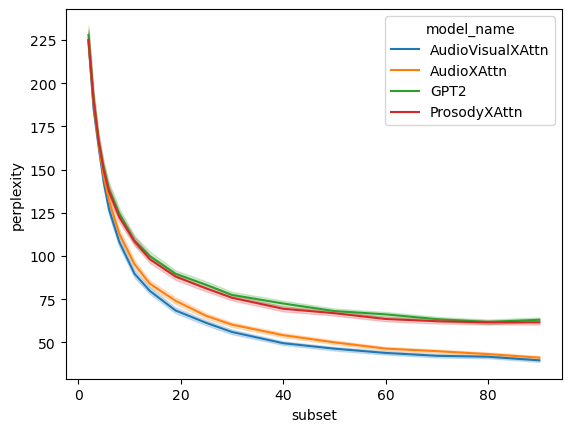

In [111]:
sns.lineplot(df_results, x='subset', y='perplexity', hue='model_name')

In [169]:
import careful_whisper_utils as utils

# Find equivalent points and ratios
df_comparisons, curves = utils.find_all_model_comparisons(
    df_results, 
    main_models=['AudioVisualXAttn', 'AudioXAttn', 'ProsodyXAttn'],
    comparison_model=['GPT2'], 
    kind='power',
    group=True
)


Comparing AudioVisualXAttn and GPT2
Exponential_decay Fit:
  Initial Guess: [0.5, 0.02, 0.2]
  Fitted Params: [ 1.04168480e-02 -2.82000556e+01  2.91650548e+00]
  R-squared: 0.9971
  RMSE: 1.5313

Could not fit power_law: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Exponential_decay Fit:
  Initial Guess: [0.5, 0.02, 0.2]
  Fitted Params: [1.69425496e+03 7.68640505e-02 6.17862102e+00]
  R-squared: 0.9867
  RMSE: 3.2731

Power_law Fit:
  Initial Guess: [0.5, 1, 0.5]
  Fitted Params: [ 2.07133079e+03 -2.80406472e+01  1.27274290e+00]
  R-squared: 0.9968
  RMSE: 1.6063



Comparison for AudioVisualXAttn and GPT2
Best curve accuracy: exponential_decay, R2 = 0.9970976565704892
Best curve perplexity: power_law, R2 = 0.9968060665195296
Comparing AudioXAttn and GPT2
Exponential_decay Fit:
  Initial Guess: [0.5, 0.02, 0.2]
  Fitted Params: [  0.05378504 -23.60529849   0.70930546]
  R-squared: 0.9993
  RMSE: 0.7256

Could not fit power_law: Optimal paramete

In [170]:
TOTAL_HOURS = 1065
dfs = []

for i, df in df_comparisons.groupby('true_subset'):
    df['hours'] = (i / 100) * TOTAL_HOURS
    dfs.append(df)
            
df_comparisons = pd.concat(dfs).reset_index(drop=True)

958.5
Exponential_decay Fit:
  Initial Guess: [0.5, 0.02, 0.2]
  Fitted Params: [1.04589784 0.00910966 0.20888582]
  R-squared: 0.9809
  RMSE: 0.0315

Power_law Fit:
  Initial Guess: [0.5, 1, 0.5]
  Fitted Params: [  5.34074186 -18.86901412   0.50254134]
  R-squared: 0.9996
  RMSE: 0.0048

Exponential_decay Fit:
  Initial Guess: [0.5, 0.02, 0.2]
  Fitted Params: [0.7641381  0.00574243 0.25777543]
  R-squared: 0.9825
  RMSE: 0.0267

Power_law Fit:
  Initial Guess: [0.5, 1, 0.5]
  Fitted Params: [ 6.02958207 10.10624009  0.46994242]
  R-squared: 0.9974
  RMSE: 0.0103

Exponential_decay Fit:
  Initial Guess: [0.5, 0.02, 0.2]
  Fitted Params: [9.39781156 0.06927408 0.84015545]
  R-squared: 0.7391
  RMSE: 0.0384



/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/careful_whisper_utils.py:169: RuntimeWarning: invalid value encountered in power
  return a * (x + b)**(-c)
/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/careful_whisper_utils.py:169: RuntimeWarning: invalid value encountered in power
  return a * (x + b)**(-c)
/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/careful_whisper_utils.py:169: RuntimeWarning: invalid value encountered in power
  return a * (x + b)**(-c)


Power_law Fit:
  Initial Guess: [0.5, 1, 0.5]
  Fitted Params: [ 9.09295675e-01 -5.32499983e+01  1.24396355e-02]
  R-squared: 0.6002
  RMSE: 0.0475

2


/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/careful_whisper_utils.py:374: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[counter].set_yticklabels(['{:.0%}'.format(x) for x in ticks])


Exponential_decay Fit:
  Initial Guess: [0.5, 0.02, 0.2]
  Fitted Params: [0.75192191 0.00448162 0.28118427]
  R-squared: 0.9886
  RMSE: 0.0224

Power_law Fit:
  Initial Guess: [0.5, 1, 0.5]
  Fitted Params: [11.58475539 59.38898874  0.54078066]
  R-squared: 0.9977
  RMSE: 0.0101

Exponential_decay Fit:
  Initial Guess: [0.5, 0.02, 0.2]
  Fitted Params: [0.67309644 0.00314149 0.30540246]
  R-squared: 0.9915
  RMSE: 0.0176

Power_law Fit:
  Initial Guess: [0.5, 1, 0.5]
  Fitted Params: [ 24.4292409  170.01518521   0.61248433]
  R-squared: 0.9963
  RMSE: 0.0115

Exponential_decay Fit:
  Initial Guess: [0.5, 0.02, 0.2]
  Fitted Params: [0.92498919 0.0173091  0.86788138]
  R-squared: 0.8529
  RMSE: 0.0503



/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/careful_whisper_utils.py:169: RuntimeWarning: invalid value encountered in power
  return a * (x + b)**(-c)
/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/careful_whisper_utils.py:169: RuntimeWarning: invalid value encountered in power
  return a * (x + b)**(-c)
/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/careful_whisper_utils.py:169: RuntimeWarning: invalid value encountered in power
  return a * (x + b)**(-c)


Power_law Fit:
  Initial Guess: [0.5, 1, 0.5]
  Fitted Params: [  1.3472769  -50.25864972   0.07115608]
  R-squared: 0.7773
  RMSE: 0.0618

4


/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/careful_whisper_utils.py:374: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[counter].set_yticklabels(['{:.0%}'.format(x) for x in ticks])


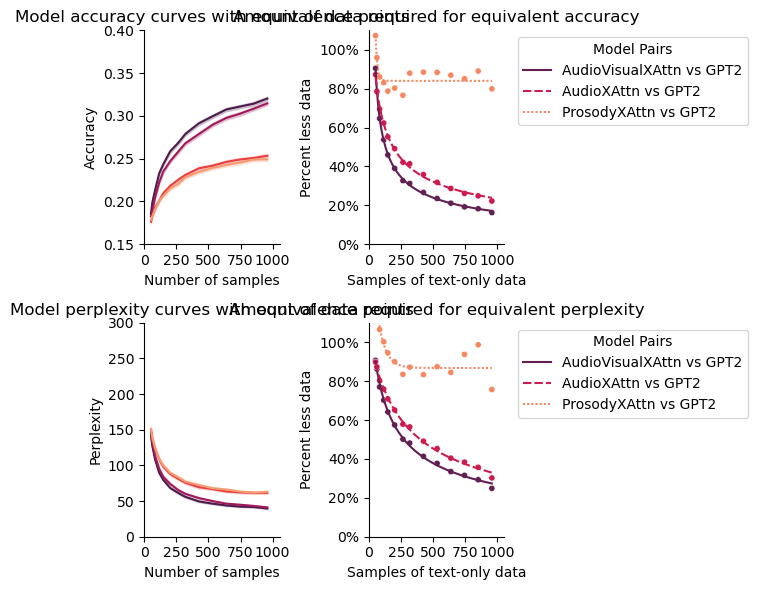

In [171]:
df_visual = df_comparisons[df_comparisons['true_subset'] >= 5]
ax = utils.plot_all_comparisons(df_visual, 'GPT2', x_axis='hours', palette='rocket', remove_outliers=False)

/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/careful_whisper_utils.py:346: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[counter].set_yticklabels(['{:.0%}'.format(x) for x in ticks])


2


/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/careful_whisper_utils.py:346: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[counter].set_yticklabels(['{:.0%}'.format(x) for x in ticks])


4


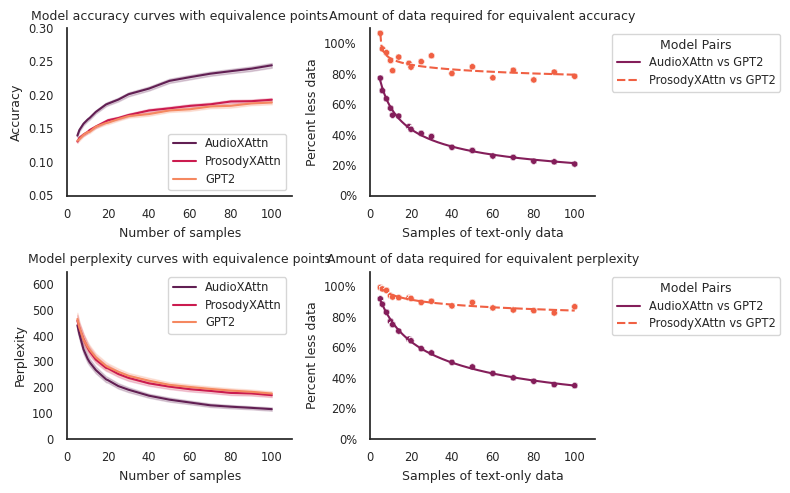

In [ ]:
import seaborn as sns
# sns.reset_orig()
# Turn off the grid using "white" style
sns.set_theme(font_scale=0.75) 
sns.set_style("white")

df_visual = df_comparisons[df_comparisons['true_subset'] >= 5]

ax = whisper.plot_all_comparisons(df_visual, 'GPT2', palette='rocket', remove_outliers=False)

## Test model loading and forward

In [75]:
import hydra
from hydra import initialize, compose
import pyrootutils
from lightning import Callback, LightningDataModule, LightningModule, Trainer
from lightning.pytorch.loggers import Logger
import lightning as L
from src import utils
from src.utils.torch_utils import tensor_to_list

def load_model(config_path, ckpt_path, overrides):
    
    with initialize(version_base="1.3", config_path=config_path):
      cfg = compose(config_name="train.yaml", overrides=overrides)

    model: LightningModule = hydra.utils.instantiate(cfg.model)

    # print("Instantiating loggers...")
    # logger: List[Logger] = utils.instantiate_loggers(cfg.get("logger"))

    print(f"Instantiating trainer <{cfg.trainer._target_}>")
    trainer: Trainer = hydra.utils.instantiate(
        cfg.trainer,
    )

    # # Load the model from a checkpoint
    # checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
    # model.load_state_dict(checkpoint['state_dict'])
    # model.eval()

    return cfg, model, trainer

In [76]:
dataset = 'av-combined'

MODELS_DIR = os.path.join(BASE_DIR, 'code/modeling/careful-whisper/')
CKPTS_DIR = os.path.join(MODELS_DIR, f'logs/train/careful-whisper/{dataset}/')

EXPERIMENT = ["experiment=careful_whisper.yaml"]

pyrootutils.setup_root(MODELS_DIR, indicator=".project-root", pythonpath=True)


# Whisper w/ CLM integration
overrides =  [
    # f"model.config.num_layers=6",
    f"model.config.cross_attention=True",
    f"model.config.use_causal_cross_attention=True",

    # Prosody embedding information
    f"model.config.context_type=audiovisual_features",
    f"model.config.context_embed_dropout=0.1",
    f"model.config.context_pos_embed=True",

    # for prosody
    # f"model.config.context_type=prominence",
    # f"model.config.context_dim=1",
]

overrides = EXPERIMENT + overrides

# # Get relative path --> path for initialize needs to be relative
config_path = os.path.join(os.path.relpath(MODELS_DIR, os.getcwd()), 'configs')

model_name = 'audio-careful-whisper_causal-xattn_subset-090'
ckpt_path = sorted(glob.glob(os.path.join(CKPTS_DIR, model_name, 'checkpoints', 'epoch*.ckpt')))[-1]

cfg, model, trainer = load_model(config_path, ckpt_path, overrides)

Instantiating trainer <lightning.pytorch.trainer.Trainer>


InterpolationResolutionError: ValueError raised while resolving interpolation: HydraConfig was not set

In [60]:
ckpt_path

'/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/modeling/careful-whisper/logs/train/careful-whisper/av-combined/audio-careful-whisper_causal-xattn_subset-090/checkpoints/epoch_014.ckpt'

In [ ]:
CKPTS_DIR = os.path.join(MODELS_DIR, f'logs/train/careful-whisper/{p.train_dataset}/')

## Visualize cross attention patterns

### Model loading

In [ ]:
import torch

import hydra
from hydra import initialize, compose
from lightning import LightningDataModule, LightningModule

import pyrootutils

from src import utils
from src.data.components.audio_text_dataset import AudioTextDataset
from src.data.components.collators import audio_text_collator

def load_model(config_path, overrides, ckpt_path=None):
    
    with initialize(version_base="1.3", config_path=config_path):
      cfg = compose(config_name="train.yaml", overrides=overrides)

    model: LightningModule = hydra.utils.instantiate(cfg.model)

    # Load the model from a checkpoint
    if ckpt_path:
      checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
      model.load_state_dict(checkpoint['state_dict'])
      model.eval()

    return cfg, model

In [ ]:
dataset = 'gigaspeech-m'
model_name = 'careful-whisper_causal-xattn-subset-0.30'
MODELS_DIR = os.path.join(BASE_DIR, 'code/modeling/joint-clm-prosody/')
CKPTS_DIR = os.path.join(MODELS_DIR, f'logs/train/careful-whisper/{dataset}/')

EXPERIMENT = ["experiment=careful_whisper.yaml"]

# Whisper w/ CLM integration
overrides =  [
    # f"model.config.num_layers=6",
    f"model.config.cross_attention=True",
    f"model.config.use_causal_cross_attention=True",

    # Add in dropout and position embedding
    f"model.config.context_embed_dropout=0.1",
    f"model.config.context_pos_embed=True",

    # for prosody
    # f"model.config.context_type=prominence",
    # f"model.config.context_dim=1",
]

overrides = EXPERIMENT + overrides

pyrootutils.setup_root(MODELS_DIR, indicator=".project-root", pythonpath=True)

# # Get relative path --> path for initialize needs to be relative
config_path = os.path.join(os.path.relpath(MODELS_DIR, os.getcwd()), 'configs')
# cfg, model = load_model(config_path, ckpt_path, overrides)

### Visualization functions

In [ ]:
from typing import List, Optional, Union


import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

class AttentionWeightTracker(nn.Module):
    """
    Wrapper to track cross-attention weights from MultiheadAttention
    """
    def __init__(self, attention_module):
        super().__init__()
        self.attn = attention_module
        self.last_qk = None
    
    def forward(self, query, key, value, key_padding_mask=None, attn_mask=None, is_causal=False):
        # Perform standard attention
        wv, qk = self.attn(
            query, key, value, 
            key_padding_mask=key_padding_mask,
            attn_mask=attn_mask,
            is_causal=is_causal
        )
        
        # Store attention weights
        self.last_qk = qk.detach()
        
        return wv, qk

# def visualize_cross_attention(attention_weights): #, input_tokens=None, target_tokens=None):
#     """
#     Visualize cross-attention patterns between input and target sequences.
    
#     Args:
#     - attention_weights: Tensor of cross-attention weights (shape: target_len x input_len)
#     - input_tokens: List of input token representations
#     - target_tokens: List of target token representations
#     """
#     plt.figure(figsize=(12, 8))
#     sns.heatmap(
#         attention_weights.squeeze().detach().numpy(), 
#         # xticklabels=input_tokens, 
#         # yticklabels=target_tokens,
#         cmap='viridis'
#     )
#     plt.title('Cross-Attention Patterns')
#     plt.xlabel('Input Sequence')
#     plt.ylabel('Target Sequence')
#     plt.tight_layout()
#     plt.show()

def visualize_cross_attention(
    attention_weights: torch.Tensor, 
    # input_tokens: Optional[List[str]] = None, 
    # target_tokens: Optional[List[str]] = None,
    # titles: Optional[List[str]] = None,
    max_subplots: int = None,
    plots_division: int = 4
):
    """
    Visualize multiple cross-attention weight matrices.
    
    Args:
    - attention_weights: Tensor or list of tensors of attention weights
    - input_tokens: Optional list of input token labels
    - target_tokens: Optional list of target token labels
    - titles: Optional list of subplot titles
    - max_subplots: Maximum number of subplots to display
    """
    # Convert single tensor to list if needed
    # if isinstance(attention_weights, torch.Tensor):
    #     attention_weights = [attention_weights]
    
    # Limit number of subplots
    attention_weights = attention_weights[:max_subplots]
    
    # Determine subplot layout
    n_plots = len(attention_weights)
    rows = (n_plots + 1) // plots_division  # Ceil division
    cols = min(n_plots, plots_division)
    
    # Create figure
    plt.figure(figsize=(6*cols, 5*rows))
    
    # Plot each attention weight matrix
    for i, weights in enumerate(attention_weights, 1):
        plt.subplot(rows, cols, i)
        
        # Transpose to match desired orientation
        weights_np = weights.squeeze().detach().cpu().numpy().T
        
        sns.heatmap(
            weights_np, 
            # xticklabels=target_tokens, 
            # yticklabels=input_tokens,
            cmap='viridis',
            cbar=False,
            square=True
        )
        
        # Set title
        # if titles and i <= len(titles):
        #     plt.title(titles[i-1])
        # else:
        plt.title(f'Attention Matrix {i}')

        plt.xlabel('Target')
        plt.ylabel('Input')
    
    plt.tight_layout()
    plt.show()

def extract_cross_attention(model, batch):
    """
    Extract cross-attention weights from a transformer model.
    
    Returns:
    - Aggregated cross-attention weights across layers
    """
    # Wrap cross-attention layers with weight tracker

    model = deepcopy(model)

    attention_trackers = []
    for block in model.model.blocks:
        original_cross_attn = block.cross_attn.attn
        tracked_cross_attn = AttentionWeightTracker(original_cross_attn)
        block.cross_attn.attn = tracked_cross_attn
        attention_trackers.append(tracked_cross_attn)
    
    # Perform forward pass
    with torch.no_grad():
        model(batch)
    
    # Collect weights
    weights = [tracker.last_qk for tracker in attention_trackers]
    
    # Restore original attention modules
    for i, block in enumerate(model.model.blocks):
        block.cross_attn.attn = attention_trackers[i].attn
    
    # Aggregate weights
    return torch.stack(weights) #.mean(dim=0)

### Grab data for visualization

In [ ]:
for i, batch in enumerate(dataloader):
    if i == 10:

        sys.exit(0)

/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/modeling/joint-clm-prosody/src/data/components/audio_text_dataset.py:646: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat

SystemExit: 0

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Visualize XAttn Patterns

#### 10% of data XAttn

/scratch/ipykernel_459143/175680163.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))


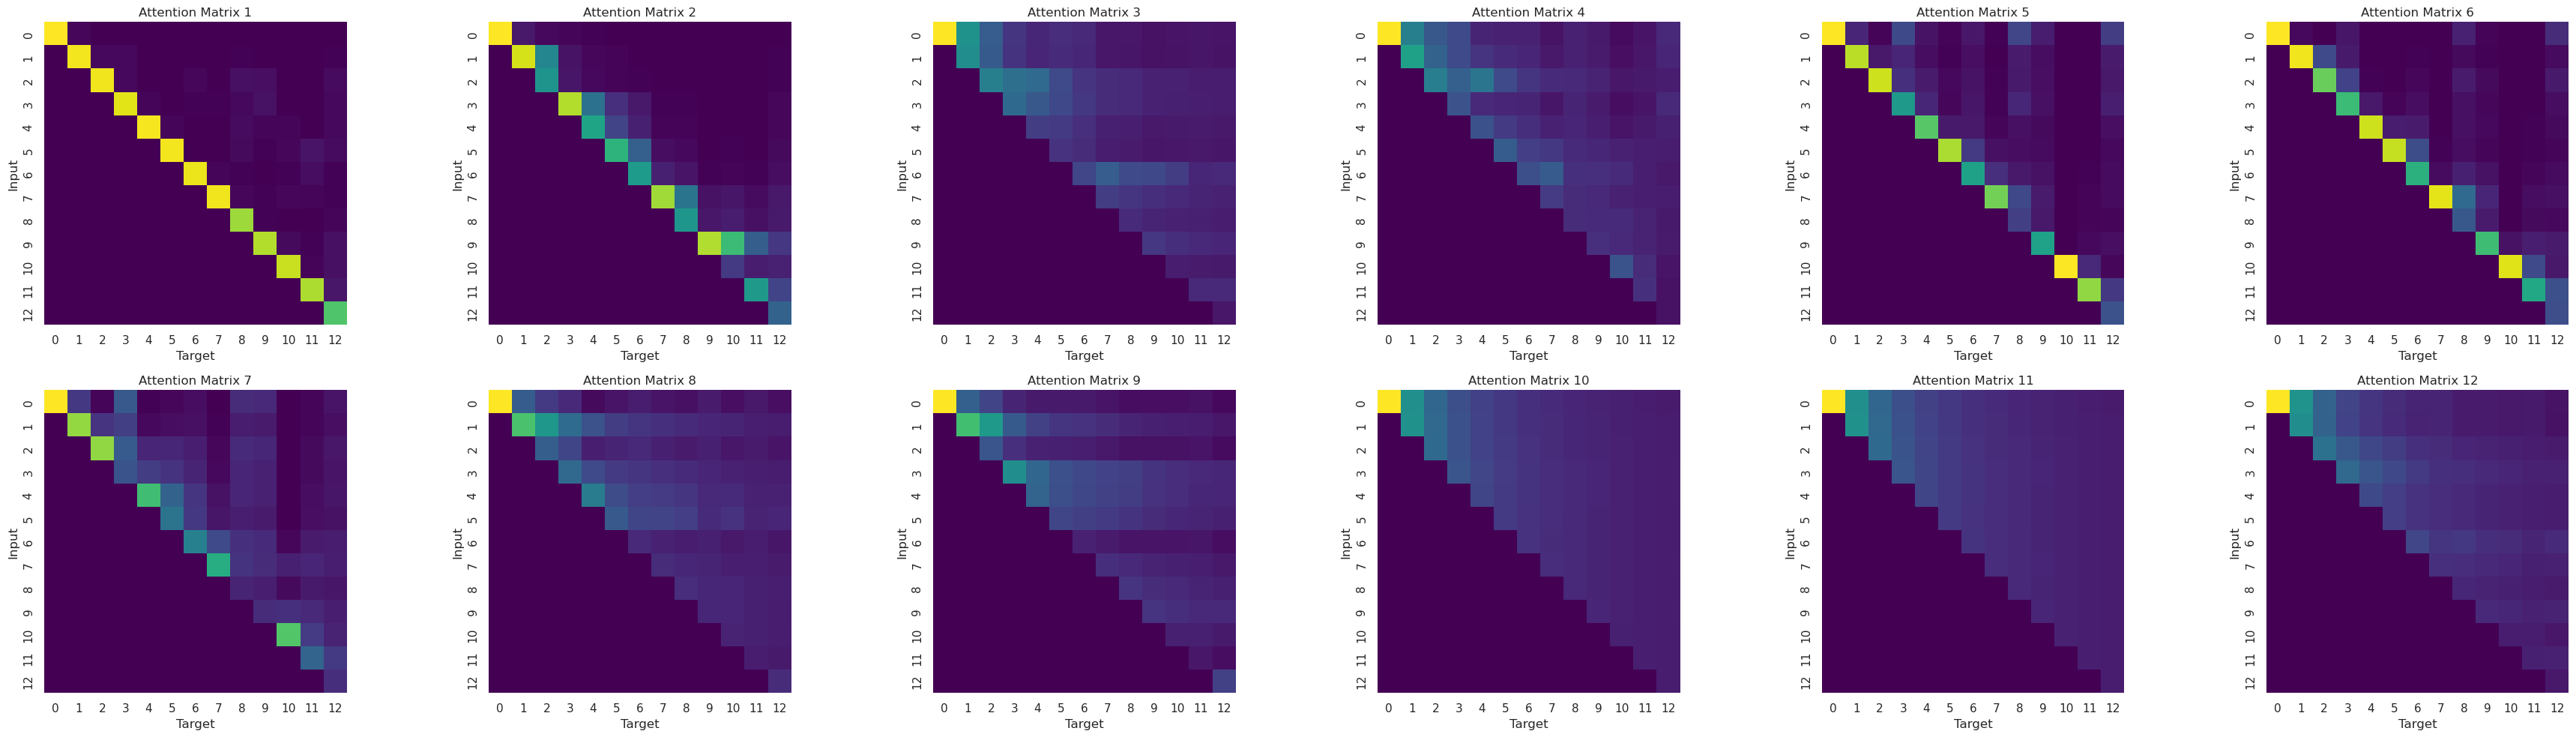

Text(0.5, 0.98, '10% data XAttn')

<Figure size 640x480 with 0 Axes>

In [ ]:
model_name = 'careful-whisper_causal-xattn-subset-0.10'
ckpt_path = glob.glob(os.path.join(CKPTS_DIR, model_name, 'checkpoints', 'epoch*.ckpt'))[-1]
cfg, model = load_model(config_path, ckpt_path, overrides)

attention_weights = extract_cross_attention(model, batch)

visualize_cross_attention(attention_weights.squeeze(), plots_division=6)
plt.suptitle(f'10% data XAttn')

#### 30% of data XAttn

/scratch/ipykernel_459143/175680163.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))


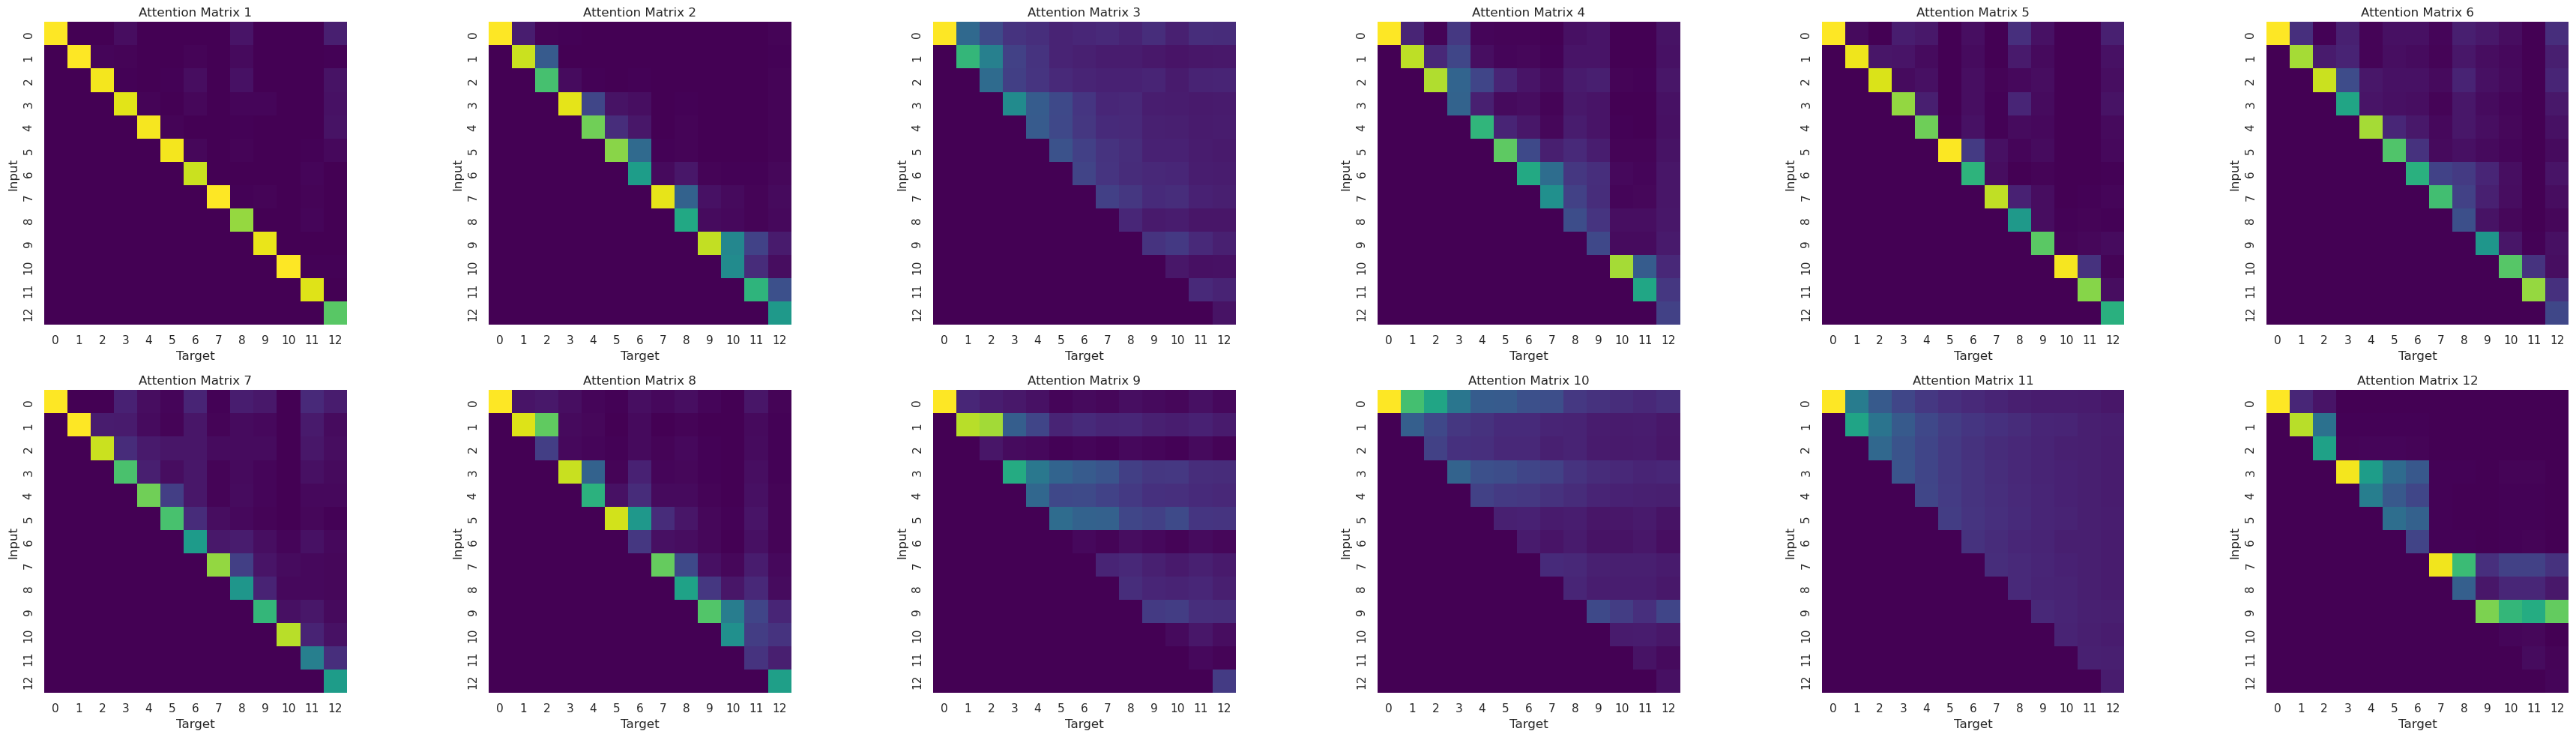

Text(0.5, 0.98, '30% data XAttn')

<Figure size 640x480 with 0 Axes>

In [ ]:
model_name = 'careful-whisper_causal-xattn-subset-0.30'
ckpt_path = glob.glob(os.path.join(CKPTS_DIR, model_name, 'checkpoints', 'epoch*.ckpt'))[-1]
cfg, model = load_model(config_path, ckpt_path, overrides)

attention_weights = extract_cross_attention(model, batch)

visualize_cross_attention(attention_weights.squeeze(), plots_division=6)
plt.suptitle(f'30% data XAttn')

#### 50% data XAttn

/scratch/ipykernel_459143/175680163.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))


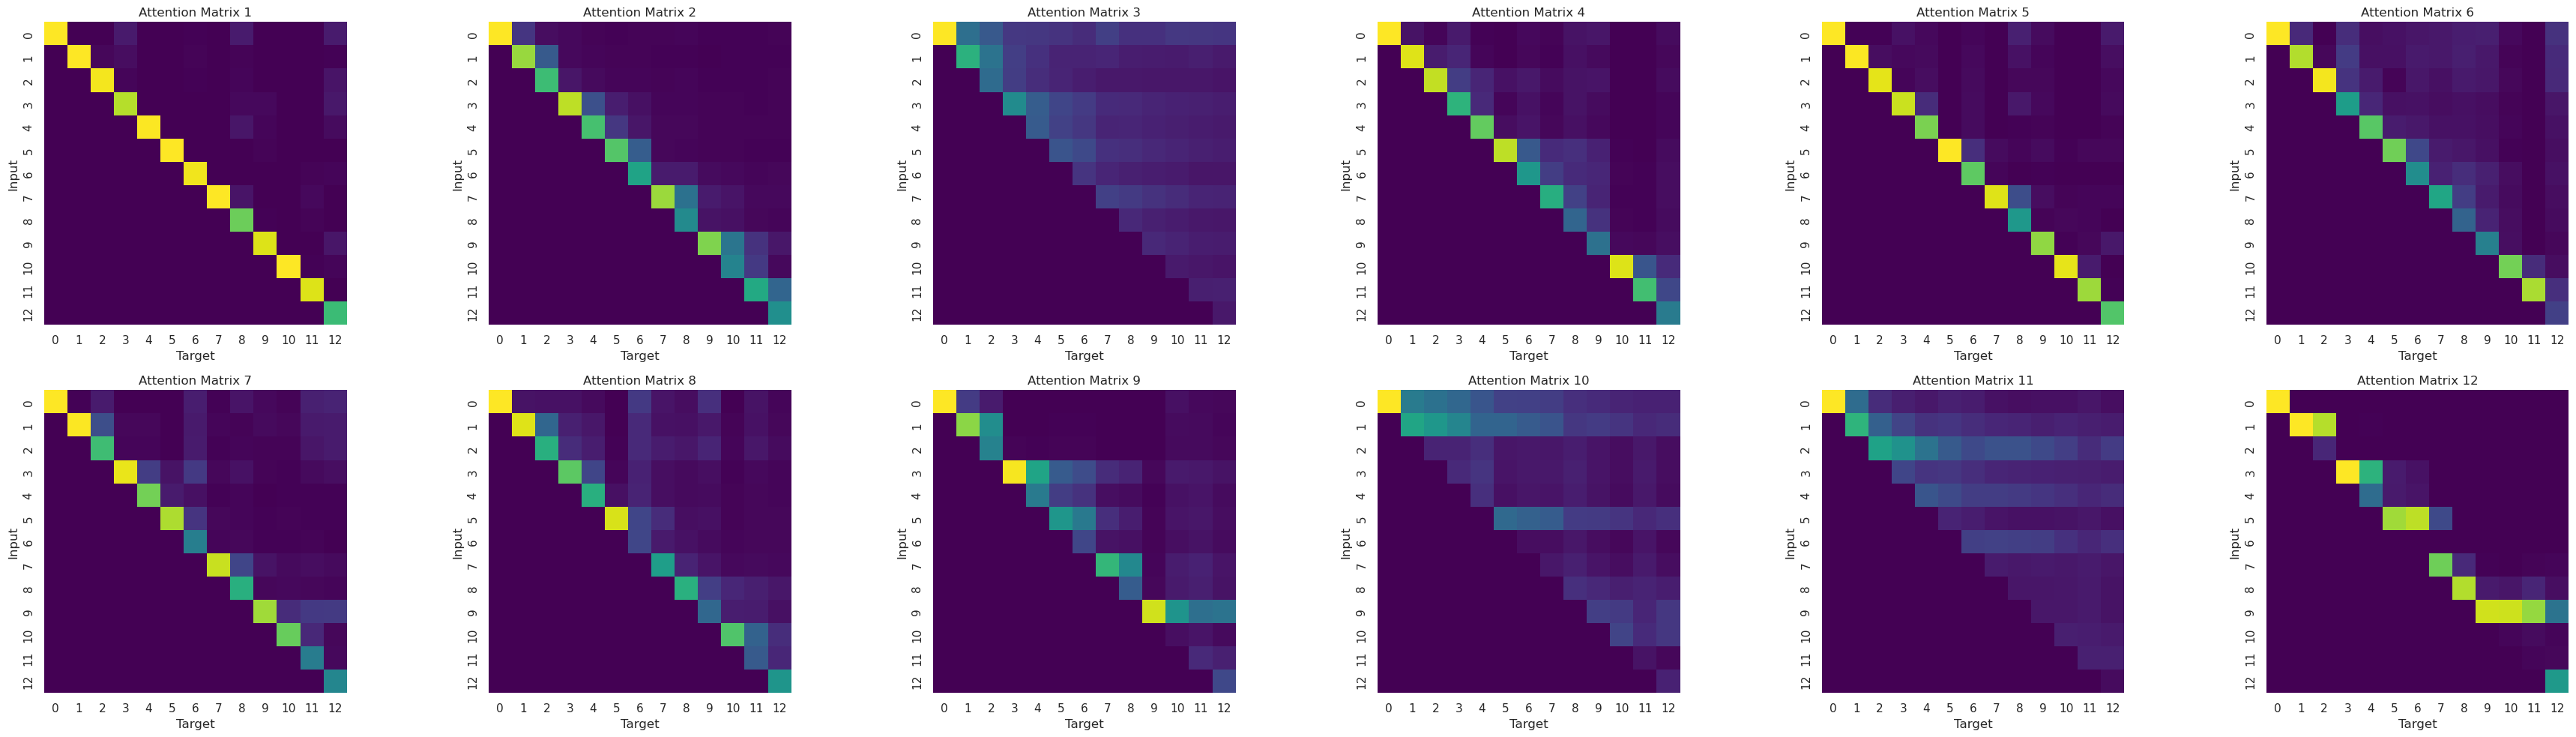

Text(0.5, 0.98, '50% data XAttn')

<Figure size 640x480 with 0 Axes>

In [ ]:
model_name = 'careful-whisper_causal-xattn-subset-0.50'
ckpt_path = glob.glob(os.path.join(CKPTS_DIR, model_name, 'checkpoints', 'epoch*.ckpt'))[-1]
cfg, model = load_model(config_path, ckpt_path, overrides)

attention_weights = extract_cross_attention(model, batch)

visualize_cross_attention(attention_weights.squeeze(), plots_division=6)
plt.suptitle(f'50% data XAttn')

#### 100% data XAttn

/scratch/ipykernel_459143/175680163.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))


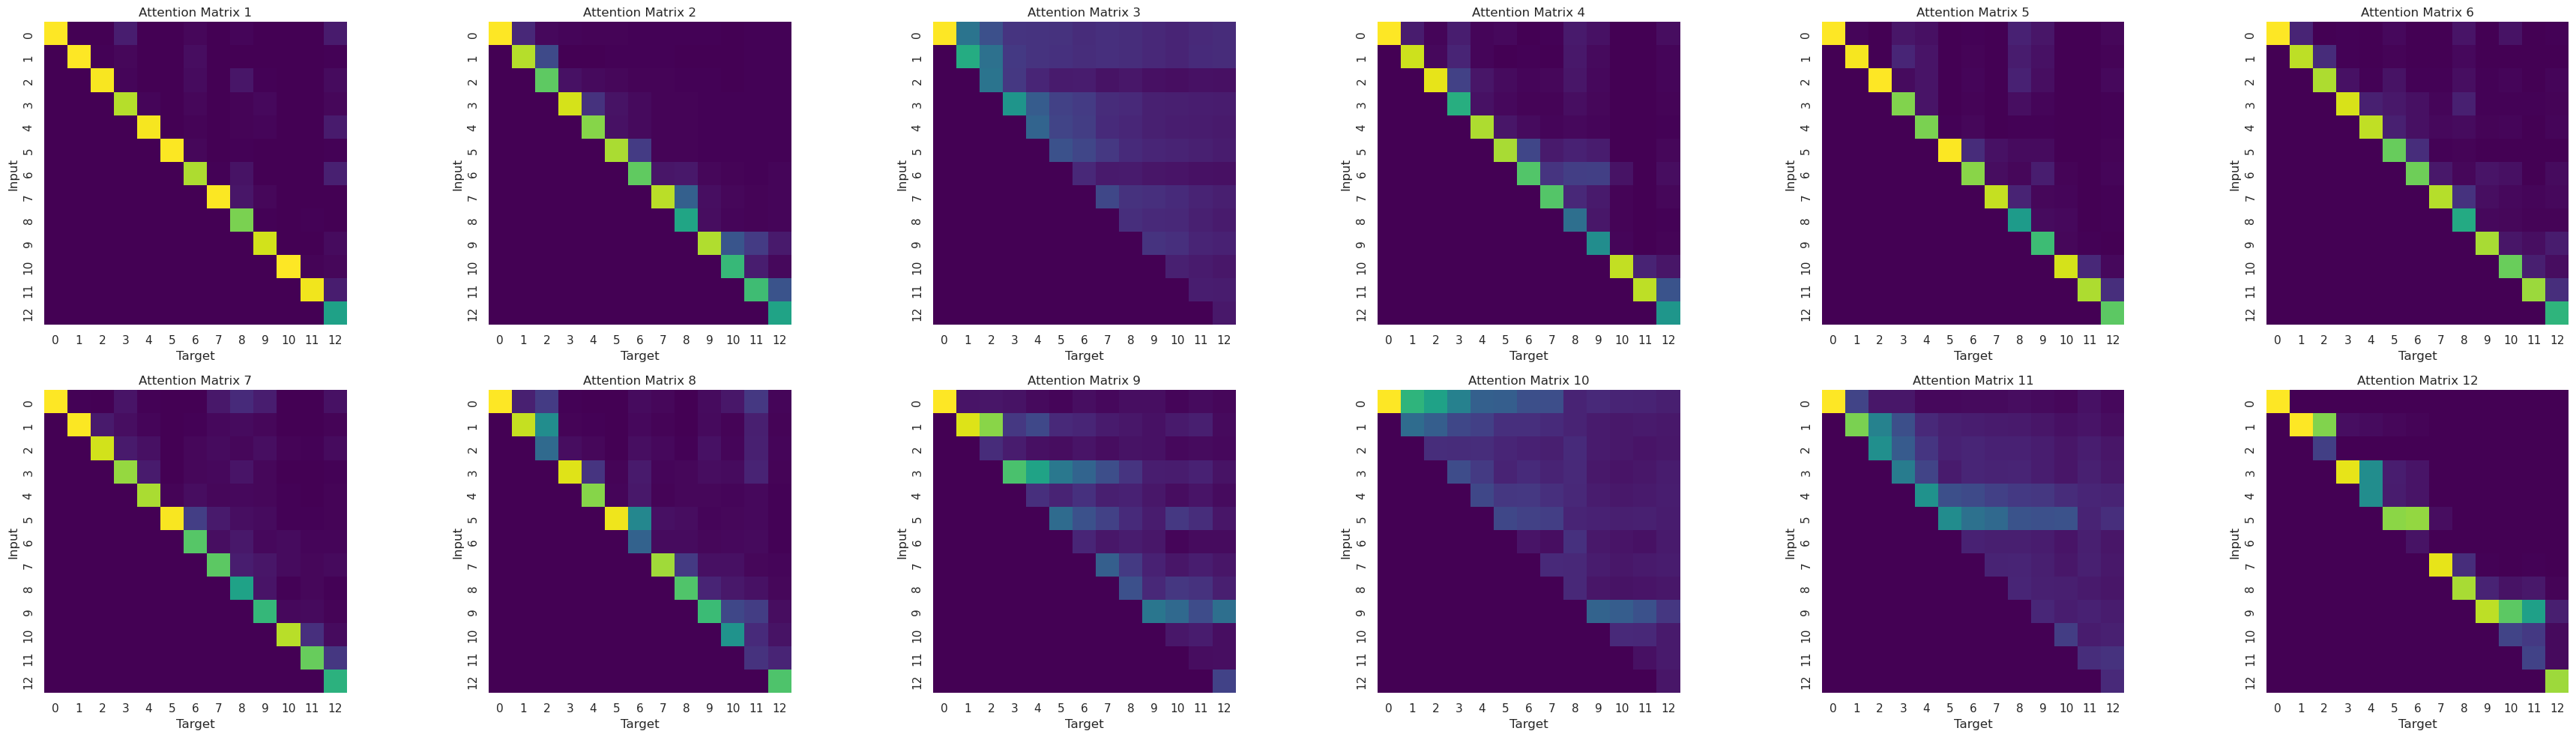

Text(0.5, 0.98, '100% data XAttn')

<Figure size 640x480 with 0 Axes>

In [ ]:
model_name = 'careful-whisper_causal-xattn'
ckpt_path = glob.glob(os.path.join(CKPTS_DIR, model_name, 'checkpoints', 'epoch*.ckpt'))[-1]
cfg, model = load_model(config_path, ckpt_path, overrides)

attention_weights = extract_cross_attention(model, batch)

visualize_cross_attention(attention_weights.squeeze(), plots_division=6)
plt.suptitle(f'100% data XAttn')